In [1]:
import numpy as np 
import random
import matplotlib.pyplot as plt # Graphical library
#from sklearn.metrics import mean_squared_error # Mean-squared error function

# Coursework 1 :
See pdf for instructions. 

In [2]:
# WARNING: fill in these two functions that will be used by the auto-marking script
# [Action required]

def get_CID():
  return "01715447" # Return your CID (add 0 at the beginning to ensure it is 8 digits long)

def get_login():
  return "aa1719" # Return your short imperial login

## Helper class

In [3]:
# This class is used ONLY for graphics
# YOU DO NOT NEED to understand it to work on this coursework

class GraphicsMaze(object):

  def __init__(self, shape, locations, default_reward, obstacle_locs, absorbing_locs, absorbing_rewards, absorbing):

    self.shape = shape
    self.locations = locations
    self.absorbing = absorbing

    # Walls
    self.walls = np.zeros(self.shape)
    for ob in obstacle_locs:
      self.walls[ob] = 20

    # Rewards
    self.rewarders = np.ones(self.shape) * default_reward
    for i, rew in enumerate(absorbing_locs):
      self.rewarders[rew] = 10 if absorbing_rewards[i] > 0 else -10

    # Print the map to show it
    self.paint_maps()

  def paint_maps(self):
    """
    Print the Maze topology (obstacles, absorbing states and rewards)
    input: /
    output: /
    """
    plt.figure(figsize=(15,10))
    plt.imshow(self.walls + self.rewarders)
    plt.show()

  def paint_state(self, state):
    """
    Print one state on the Maze topology (obstacles, absorbing states and rewards)
    input: /
    output: /
    """
    states = np.zeros(self.shape)
    states[state] = 30
    plt.figure(figsize=(15,10))
    plt.imshow(self.walls + self.rewarders + states)
    plt.show()

  def draw_deterministic_policy(self, Policy):
    """
    Draw a deterministic policy
    input: Policy {np.array} -- policy to draw (should be an array of values between 0 and 3 (actions))
    output: /
    """
    plt.figure(figsize=(15,10))
    plt.imshow(self.walls + self.rewarders) # Create the graph of the Maze
    for state, action in enumerate(Policy):
      if(self.absorbing[0,state]): # If it is an absorbing state, don't plot any action
        continue
      arrows = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"] # List of arrows corresponding to each possible action
      action_arrow = arrows[action] # Take the corresponding action
      location = self.locations[state] # Compute its location on graph
      plt.text(location[1], location[0], action_arrow, ha='center', va='center') # Place it on graph
    plt.show()

  def draw_policy(self, Policy):
    """
    Draw a policy (draw an arrow in the most probable direction)
    input: Policy {np.array} -- policy to draw as probability
    output: /
    """
    deterministic_policy = np.array([np.argmax(Policy[row,:]) for row in range(Policy.shape[0])])
    self.draw_deterministic_policy(deterministic_policy)

  def draw_value(self, Value):
    """
    Draw a policy value
    input: Value {np.array} -- policy values to draw
    output: /
    """
    plt.figure(figsize=(15,10))
    plt.imshow(self.walls + self.rewarders) # Create the graph of the Maze
    for state, value in enumerate(Value):
      if(self.absorbing[0, state]): # If it is an absorbing state, don't plot any value
        continue
      location = self.locations[state] # Compute the value location on graph
      plt.text(location[1], location[0], round(value,2), ha='center', va='center') # Place it on graph
    plt.show()

  def draw_deterministic_policy_grid(self, Policies, title, n_columns, n_lines):
    """
    Draw a grid representing multiple deterministic policies
    input: Policies {np.array of np.array} -- array of policies to draw (each should be an array of values between 0 and 3 (actions))
    output: /
    """
    plt.figure(figsize=(20,8))
    for subplot in range (len(Policies)): # Go through all policies
      ax = plt.subplot(n_columns, n_lines, subplot+1) # Create a subplot for each policy
      ax.imshow(self.walls+self.rewarders) # Create the graph of the Maze
      for state, action in enumerate(Policies[subplot]):
        if(self.absorbing[0,state]): # If it is an absorbing state, don't plot any action
          continue
        arrows = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"] # List of arrows corresponding to each possible action
        action_arrow = arrows[action] # Take the corresponding action
        location = self.locations[state] # Compute its location on graph
        plt.text(location[1], location[0], action_arrow, ha='center', va='center') # Place it on graph
      ax.title.set_text(title[subplot]) # Set the title for the graph given as argument
    plt.show()

  def draw_policy_grid(self, Policies, title, n_columns, n_lines):
    """
    Draw a grid representing multiple policies (draw an arrow in the most probable direction)
    input: Policy {np.array} -- array of policies to draw as probability
    output: /
    """
    deterministic_policies = np.array([[np.argmax(Policy[row,:]) for row in range(Policy.shape[0])] for Policy in Policies])
    self.draw_deterministic_policy_grid(deterministic_policies, title, n_columns, n_lines)

  def draw_value_grid(self, Values, title, n_columns, n_lines):
    """
    Draw a grid representing multiple policy values
    input: Values {np.array of np.array} -- array of policy values to draw
    output: /
    """
    plt.figure(figsize=(20,8))
    for subplot in range (len(Values)): # Go through all values
      ax = plt.subplot(n_columns, n_lines, subplot+1) # Create a subplot for each value
      ax.imshow(self.walls+self.rewarders) # Create the graph of the Maze
      for state, value in enumerate(Values[subplot]):
        if(self.absorbing[0,state]): # If it is an absorbing state, don't plot any value
          continue
        location = self.locations[state] # Compute the value location on graph
        plt.text(location[1], location[0], round(value,1), ha='center', va='center') # Place it on graph
      ax.title.set_text(title[subplot]) # Set the title for the graoh given as argument
    plt.show()


## Maze class

In [4]:
# This class define the Maze environment

class Maze(object):

  # [Action required]
  def __init__(self):
    """
    Maze initialisation.
    input: /
    output: /
    """
    
    # [Action required]
    # Properties set from the CID
    cid = "01715447" # so it's self-contained / get_CID()
    cid_second_to_last_digit =  int(cid[-2]) # In Docs this is y
    cid_last_digit = int(cid[-1]) # In docs this is z

    self._prob_success = 0.8 + 0.02 * (9 - cid_second_to_last_digit) # float 0.8 + 0.02 * (9 - y)
    self._gamma = 0.8 + 0.02 * cid_second_to_last_digit # float 0.8 + 0.02y
    self._goal = cid_last_digit % 4 # integer (0 for R0, 1 for R1, 2 for R2, 3 for R3) z mod 4

    # Build the maze
    self._build_maze()
                              

  # Functions used to build the Maze environment 
  # You DO NOT NEED to modify them
  def _build_maze(self):
    """
    Maze initialisation.
    input: /
    output: /
    """

    # Properties of the maze
    self._shape = (13, 10)
    self._obstacle_locs = [
                          (1,0), (1,1), (1,2), (1,3), (1,4), (1,7), (1,8), (1,9), \
                          (2,1), (2,2), (2,3), (2,7), \
                          (3,1), (3,2), (3,3), (3,7), \
                          (4,1), (4,7), \
                          (5,1), (5,7), \
                          (6,5), (6,6), (6,7), \
                          (8,0), \
                          (9,0), (9,1), (9,2), (9,6), (9,7), (9,8), (9,9), \
                          (10,0)
                         ] # Location of obstacles
    self._absorbing_locs = [(2,0), (2,9), (10,1), (12,9)] # Location of absorbing states
    self._absorbing_rewards = [ (500 if (i == self._goal) else -50) for i in range (4) ]
    self._starting_locs = [(0,0), (0,1), (0,2), (0,3), (0,4), (0,5), (0,6), (0,7), (0,8), (0,9)] #Reward of absorbing states
    self._default_reward = -1 # Reward for each action performs in the environment
    self._max_t = 500 # Max number of steps in the environment

    # Actions
    self._action_size = 4
    self._direction_names = ['N','E','S','W'] # Direction 0 is 'N', 1 is 'E' and so on
        
    # States
    self._locations = []
    for i in range (self._shape[0]):
      for j in range (self._shape[1]):
        loc = (i,j) 
        # Adding the state to locations if it is no obstacle
        if self._is_location(loc):
          self._locations.append(loc)
    self._state_size = len(self._locations)

    # Neighbours - each line is a state, ranked by state-number, each column is a direction (N, E, S, W)
    self._neighbours = np.zeros((self._state_size, 4)) 
    
    for state in range(self._state_size):
      loc = self._get_loc_from_state(state)

      # North
      neighbour = (loc[0]-1, loc[1]) # North neighbours location
      if self._is_location(neighbour):
        self._neighbours[state][self._direction_names.index('N')] = self._get_state_from_loc(neighbour)
      else: # If there is no neighbour in this direction, coming back to current state
        self._neighbours[state][self._direction_names.index('N')] = state

      # East
      neighbour = (loc[0], loc[1]+1) # East neighbours location
      if self._is_location(neighbour):
        self._neighbours[state][self._direction_names.index('E')] = self._get_state_from_loc(neighbour)
      else: # If there is no neighbour in this direction, coming back to current state
        self._neighbours[state][self._direction_names.index('E')] = state

      # South
      neighbour = (loc[0]+1, loc[1]) # South neighbours location
      if self._is_location(neighbour):
        self._neighbours[state][self._direction_names.index('S')] = self._get_state_from_loc(neighbour)
      else: # If there is no neighbour in this direction, coming back to current state
        self._neighbours[state][self._direction_names.index('S')] = state

      # West
      neighbour = (loc[0], loc[1]-1) # West neighbours location
      if self._is_location(neighbour):
        self._neighbours[state][self._direction_names.index('W')] = self._get_state_from_loc(neighbour)
      else: # If there is no neighbour in this direction, coming back to current state
        self._neighbours[state][self._direction_names.index('W')] = state

    # Absorbing
    self._absorbing = np.zeros((1, self._state_size))
    for a in self._absorbing_locs:
      absorbing_state = self._get_state_from_loc(a)
      self._absorbing[0, absorbing_state] = 1

    # Transition matrix
    self._T = np.zeros((self._state_size, self._state_size, self._action_size)) # Empty matrix of domension S*S*A
    for action in range(self._action_size):
      for outcome in range(4): # For each direction (N, E, S, W)
        # The agent has prob_success probability to go in the correct direction
        if action == outcome:
          prob = 1 - 3.0 * ((1.0 - self._prob_success) / 3.0) # (theoritically equal to self.prob_success but avoid rounding error and garanty a sum of 1)
        # Equal probability to go into one of the other directions
        else:
          prob = (1.0 - self._prob_success) / 3.0
          
        # Write this probability in the transition matrix
        for prior_state in range(self._state_size):
          # If absorbing state, probability of 0 to go to any other states
          if not self._absorbing[0, prior_state]:
            post_state = self._neighbours[prior_state, outcome] # Post state number
            post_state = int(post_state) # Transform in integer to avoid error
            self._T[prior_state, post_state, action] += prob

    # Reward matrix
    self._R = np.ones((self._state_size, self._state_size, self._action_size)) # Matrix filled with 1
    self._R = self._default_reward * self._R # Set default_reward everywhere
    for i in range(len(self._absorbing_rewards)): # Set absorbing states rewards
      post_state = self._get_state_from_loc(self._absorbing_locs[i])
      self._R[:,post_state,:] = self._absorbing_rewards[i]

    # Creating the graphical Maze world
    self._graphics = GraphicsMaze(self._shape, self._locations, self._default_reward, self._obstacle_locs, self._absorbing_locs, self._absorbing_rewards, self._absorbing)
    
    # Reset the environment
    self.reset()


  def _is_location(self, loc):
    """
    Is the location a valid state (not out of Maze and not an obstacle)
    input: loc {tuple} -- location of the state
    output: _ {bool} -- is the location a valid state
    """
    if (loc[0] < 0 or loc[1] < 0 or loc[0] > self._shape[0]-1 or loc[1] > self._shape[1]-1):
      return False
    elif (loc in self._obstacle_locs):
      return False
    else:
      return True


  def _get_state_from_loc(self, loc):
    """
    Get the state number corresponding to a given location
    input: loc {tuple} -- location of the state
    output: index {int} -- corresponding state number
    """
    return self._locations.index(tuple(loc))


  def _get_loc_from_state(self, state):
    """
    Get the state number corresponding to a given location
    input: index {int} -- state number
    output: loc {tuple} -- corresponding location
    """
    return self._locations[state]

  # Getter functions used only for DP agents
  # You DO NOT NEED to modify them
  def get_T(self):
    return self._T

  def get_R(self):
    return self._R

  def get_absorbing(self):
    return self._absorbing

  # Getter functions used for DP, MC and TD agents
  # You DO NOT NEED to modify them
  def get_graphics(self):
    return self._graphics

  def get_action_size(self):
    return self._action_size

  def get_state_size(self):
    return self._state_size

  def get_gamma(self):
    return self._gamma

  # Functions used to perform episodes in the Maze environment
  def reset(self):
    """
    Reset the environment state to one of the possible starting states
    input: /
    output: 
      - t {int} -- current timestep
      - state {int} -- current state of the envionment
      - reward {int} -- current reward
      - done {bool} -- True if reach a terminal state / 0 otherwise
    """
    self._t = 0
    self._state = self._get_state_from_loc(self._starting_locs[random.randrange(len(self._starting_locs))])
    self._reward = 0
    self._done = False
    return self._t, self._state, self._reward, self._done

  def step(self, action):
    """
    Perform an action in the environment
    input: action {int} -- action to perform
    output: 
      - t {int} -- current timestep
      - state {int} -- current state of the envionment
      - reward {int} -- current reward
      - done {bool} -- True if reach a terminal state / 0 otherwise
    """

    # If environment already finished, print an error
    if self._done or self._absorbing[0, self._state]:
      print("Please reset the environment")
      return self._t, self._state, self._reward, self._done

    # Drawing a random number used for probaility of next state
    probability_success = random.uniform(0,1)

    # Look for the first possible next states (so get a reachable state even if probability_success = 0)
    new_state = 0
    while self._T[self._state, new_state, action] == 0: 
      new_state += 1
    assert self._T[self._state, new_state, action] != 0, "Selected initial state should be probability 0, something might be wrong in the environment."

    # Find the first state for which probability of occurence matches the random value
    total_probability = self._T[self._state, new_state, action]
    while (total_probability < probability_success) and (new_state < self._state_size-1):
     new_state += 1
     total_probability += self._T[self._state, new_state, action]
    assert self._T[self._state, new_state, action] != 0, "Selected state should be probability 0, something might be wrong in the environment."
    
    # Setting new t, state, reward and done
    self._t += 1
    self._reward = self._R[self._state, new_state, action]
    self._done = self._absorbing[0, new_state] or self._t > self._max_t
    self._state = new_state
    return self._t, self._state, self._reward, self._done

# Helper Functions

In [39]:
def visualize_value_function(maze_env, V, filename):
    n, m = maze_env._shape
    value_grid = np.full(maze_env._shape, np.nan)  # Create a grid full of NaNs

    # Map the value function V onto our grid
    for state in range(maze_env.get_state_size()):
        i, j = maze_env._get_loc_from_state(state)
        value_grid[i][j] = V[state]

    fig, ax = plt.subplots(figsize=(m, n))

    # Create the heatmap
    cax = ax.matshow(value_grid, cmap='viridis')  # 'viridis' is a colormap suitable for heatmaps

    # Mark obstacles and absorbing states
    for i, j in maze_env._obstacle_locs:
        ax.text(j, i, '█', ha='center', va='center', fontsize=12, color='white')
    for i, j in maze_env._absorbing_locs:
        ax.text(j, i, 'A', ha='center', va='center', fontsize=12, color='white')

    fig.colorbar(cax)

    ax.set_xticks(np.arange(-0.5, m, 1))
    ax.set_yticks(np.arange(-0.5, n, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(which='both')

    plt.savefig(filename)
    plt.close(fig)

def visualize_stochastic_policy(maze_env, policy, filename):
    n, m = maze_env._shape
    fig, ax = plt.subplots(figsize=(m, n))

    # Define a function to draw arrows based on action and probability
    def draw_arrow(x, y, action, probability):
        if action == 0:   # North
            ax.arrow(x, y, 0, -0.3, head_width=0.2, head_length=0.2, fc='k', ec='k', alpha=probability)
        elif action == 1: # East
            ax.arrow(x, y, 0.3, 0, head_width=0.2, head_length=0.2, fc='k', ec='k', alpha=probability)
        elif action == 2: # South
            ax.arrow(x, y, 0, 0.3, head_width=0.2, head_length=0.2, fc='k', ec='k', alpha=probability)
        elif action == 3: # West
            ax.arrow(x, y, -0.3, 0, head_width=0.2, head_length=0.2, fc='k', ec='k', alpha=probability)

    # Loop over states and draw arrows based on the policy probabilities
    for state in range(maze_env.get_state_size()):
        i, j = maze_env._get_loc_from_state(state)
        if (i, j) not in maze_env._obstacle_locs:
            for action, prob in enumerate(policy[state]):
                if prob > 0:  # Only draw if there's a non-zero probability
                    draw_arrow(j, i, action, prob)

    # Mark obstacles and absorbing states
    for i, j in maze_env._obstacle_locs:
        ax.text(j, i, '█', ha='center', va='center', fontsize=12, color='red')
    for i, j in maze_env._absorbing_locs:
        ax.text(j, i, 'A', ha='center', va='center', fontsize=12, color='blue')

    ax.set_xlim(-0.5, m-0.5)
    ax.set_ylim(-0.5, n-0.5)
    ax.set_xticks(np.arange(-0.5, m, 1))
    ax.set_yticks(np.arange(-0.5, n, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(which='both')
    ax.invert_yaxis()

    plt.savefig(filename)
    plt.close(fig)

def visualize_policy(maze_env, policy, filename):
    n, m = maze_env._shape
    fig, ax = plt.subplots(figsize=(m, n))

    # Directions for arrows based on action index
    directions = np.array([[0, -1], [-1, 0], [0, 1], [1, 0]])
    arrow_directions = ['↑', '→', '↓', '←']

    for state in range(maze_env.get_state_size()):
        i, j = maze_env._get_loc_from_state(state)

        # Get the action with the highest probability for the state
        best_action = np.argmax(policy[state])
        arrow = arrow_directions[best_action]

        ax.text(j, i, arrow, ha='center', va='center', fontsize=12)

    # Mark obstacles and absorbing states
    for i, j in maze_env._obstacle_locs:
        ax.text(j, i, '█', ha='center', va='center', fontsize=12, color='red')
    for i, j in maze_env._absorbing_locs:
        ax.text(j, i, 'A', ha='center', va='center', fontsize=12, color='green')

    ax.set_xticks(np.arange(-0.5, m, 1))
    ax.set_yticks(np.arange(-0.5, n, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(which='both')

    plt.savefig(filename)
    plt.close(fig)


import matplotlib.pyplot as plt

def visualize_value_and_hyperparameters(maze_env, V, hyperparams, filename):
    # Extract hyperparameters for the bar chart
    [policy_improvement, batch_limit, episodes, visit_type, exploratory_decay, exploratory_param ]= hyperparams

    # First, visualize the value function
    n, m = maze_env._shape
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(m*2, n))  # 1 row, 2 columns

    # --- Value function visualization (as you provided) ---
    value_grid = np.full(maze_env._shape, np.nan)
    for state in range(maze_env.get_state_size()):
        i, j = maze_env._get_loc_from_state(state)
        value_grid[i][j] = V[state]
    cax1 = ax1.matshow(value_grid, cmap='viridis')
    fig.colorbar(cax1, ax=ax1, orientation='vertical')

    # --- Hyperparameters Bar Chart ---
    labels = ['Batch Limit', 'Episodes', 'Visit Type', 'Exploration Decay', 'Exploration Param']
    normalized_values = [
        batch_limit / max(MC_Batch_Limit),
        episodes / max(MC_Episodes_in_Batch),
        1 if visit_type else 0,
        (exploratory_decay - min(MC_Exploration_Decay)) / (max(MC_Exploration_Decay) - min(MC_Exploration_Decay)),
        (exploratory_param - min(MC_Exploration_Params)) / (max(MC_Exploration_Params) - min(MC_Exploration_Params))
    ]

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    bars = ax2.barh(labels, normalized_values, color=colors)

    bars = ax2.barh(labels, normalized_values, color=colors)
    ax2.set_title(policy_improvement)
    ax2.set_xlim(0, 1)  # As values are normalized

    # Display the actual values on top of each bar
    for bar, value, label in zip(bars, [batch_limit, episodes, visit_type, exploratory_decay, exploratory_param], labels):
        ax2.text(bar.get_width() + 0.05, bar.get_y() + bar.get_height()/2, str(value),
                 va='center', ha='left', color='black', fontsize=10)

    plt.tight_layout()
    plt.savefig(filename)
    plt.close(fig)

def visualize_value_policy_and_hyperparameters(maze_env, V, policy, hyperparams, filename):
    # Extract hyperparameters for the bar chart
    [policy_improvement, batch_limit, episodes, visit_type, exploratory_decay, exploratory_param] = hyperparams

    # First, visualize the value function and policy
    n, m = maze_env._shape
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(m*3, n))  # 1 row, 3 columns

    # --- Value function visualization ---
    value_grid = np.full(maze_env._shape, np.nan)
    for state in range(maze_env.get_state_size()):
        i, j = maze_env._get_loc_from_state(state)
        value_grid[i][j] = V[state]
    cax1 = ax1.matshow(value_grid, cmap='viridis')
    fig.colorbar(cax1, ax=ax1, orientation='vertical')

    # --- Policy visualization ---
    for state in range(maze_env.get_state_size()):
        i, j = maze_env._get_loc_from_state(state)
        if (i, j) not in maze_env._obstacle_locs:
            for action, prob in enumerate(policy[state]):
                if prob > 0:  # Only draw if there's a non-zero probability
                    draw_arrow(ax2, j, i, action, prob)
    for i, j in maze_env._obstacle_locs:
        ax2.text(j, i, '█', ha='center', va='center', fontsize=12, color='red')
    for i, j in maze_env._absorbing_locs:
        ax2.text(j, i, 'A', ha='center', va='center', fontsize=12, color='blue')
    ax2.set_xlim(-0.5, m-0.5)
    ax2.set_ylim(-0.5, n-0.5)
    ax2.invert_yaxis()

    # --- Hyperparameters Bar Chart ---
    labels = ['Batch Limit', 'Episodes', 'Visit Type', 'Exploration Decay', 'Exploration Param']
    normalized_values = [
        batch_limit / max(MC_Batch_Limit),
        episodes / max(MC_Episodes_in_Batch),
        1 if visit_type else 0,
        (exploratory_decay - min(MC_Exploration_Decay)) / (max(MC_Exploration_Decay) - min(MC_Exploration_Decay)),
        (exploratory_param - min(MC_Exploration_Params)) / (max(MC_Exploration_Params) - min(MC_Exploration_Params))
    ]
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    bars = ax3.barh(labels, normalized_values, color=colors)
    ax3.set_title(policy_improvement)
    ax3.set_xlim(0, 1)  # As values are normalized
    for bar, value, label in zip(bars, [batch_limit, episodes, visit_type, exploratory_decay, exploratory_param], labels):
        ax3.text(bar.get_width() + 0.05, bar.get_y() + bar.get_height()/2, str(value),
                 va='center', ha='left', color='black', fontsize=10)

    plt.tight_layout()
    plt.savefig(filename)
    plt.close(fig)

def draw_arrow(ax, x, y, action, probability):
    if action == 0:   # North
        ax.arrow(x, y, 0, -0.3, head_width=0.2, head_length=0.2, fc='k', ec='k', alpha=probability)
    elif action == 1: # East
        ax.arrow(x, y, 0.3, 0, head_width=0.2, head_length=0.2, fc='k', ec='k', alpha=probability)
    elif action == 2: # South
        ax.arrow(x, y, 0, 0.3, head_width=0.2, head_length=0.2, fc='k', ec='k', alpha=probability)
    elif action == 3: # West
        ax.arrow(x, y, -0.3, 0, head_width=0.2, head_length=0.2, fc='k', ec='k', alpha=probability)


## DP Agent

In [6]:
# This class define the Dynamic Programing agent 

class DP_agent(object):

  # [Action required]
  # WARNING: make sure this function can be called by the auto-marking script
  def solve(self, env):
    """
    Solve a given Maze environment using Dynamic Programming
    input: env {Maze object} -- Maze to solve
    output: 
      - policy {np.array} -- Optimal policy found to solve the given Maze environment 
      - V {np.array} -- Corresponding value function 
    """
    
    # Initialisation (can be edited)
    policy = np.zeros((env.get_state_size(), env.get_action_size())) 
    V = np.zeros(env.get_state_size())

    #### 
    # Add your code here
    # WARNING: for this agent only, you are allowed to access env.get_T(), env.get_R() and env.get_absorbing()
    ####
    transition_matrix = env.get_T()
    reward_matrix = env.get_R()
    absorbing = env.get_absorbing()
    discount_factor = env.get_gamma()

    RECORD_PROGRESS = False
    is_policy_stable = False
    iteration_steps = 1

    while not is_policy_stable:
      # print("iteration step: ", iteration_steps)
      if RECORD_PROGRESS:
        visualize_value_function(env, V, filename=f"./images/DP/ValueFunction/V-Value-Iteration-{iteration_steps}.png")
        visualize_stochastic_policy(env, policy, filename=f"./images/DP/Policy/Policy-Iteration-{iteration_steps}.png")

      policy_iteration = self.iterate_policy(
        policy=policy,
        transition_matrix=transition_matrix,
        reward_matrix=reward_matrix,
        discount_factor=discount_factor,
        V=V,
        states=range(env.get_state_size()),
        actions=range(env.get_action_size())
      )

      V_iteration = self.evaluate_policy(
        transition_matrix=transition_matrix,
        reward_matrix=reward_matrix,
        discount_factor=discount_factor,
        V=V,
        policy=policy_iteration,
        states=range(env.get_state_size()),
        actions=range(env.get_action_size())
      )

      mean_absolute_difference = np.mean(np.abs(V - V_iteration))
      max_absolute_difference = np.max(np.abs(V - V_iteration))

      print("Policy Mean Absolute Difference:", mean_absolute_difference)
      print("Policy Max Absolute Difference:", max_absolute_difference)

      # print(policy, policy_iteration)
      if max_absolute_difference <= 1e-10:
        is_policy_stable = True

      policy, V = policy_iteration, V_iteration
      iteration_steps += 1


    return policy, V

  def evaluate_policy(self, transition_matrix, reward_matrix, discount_factor, V, policy, states, actions):
    policy_eval = np.copy(V)
    for s in states:
      state_value = 0
      for action in actions:
        policy_action = policy[s][action]

        # Probability
        s_to_s_prime_action_reward = 0
        for s_prime in states:
          s_to_s_prime_action_reward += transition_matrix[s][s_prime][action] * (
            reward_matrix[s][s_prime][action] + discount_factor * V[s_prime]
          )

        state_value += policy_action * s_to_s_prime_action_reward
      policy_eval[s] = state_value
    return policy_eval

  def soft_max(self, x):
    # Use this to get a stocastic policy
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

  def iterate_policy(self, policy, transition_matrix, reward_matrix, discount_factor, V, states, actions):
    new_policy = np.copy(policy)

    for s in states:
      action_values = np.zeros(len(actions))
      for a in actions:
        a_value = 0
        for s_prime in states:
          s_a_s_prime_value = transition_matrix[s][s_prime][a] * (
            reward_matrix[s][s_prime][a] + discount_factor * (V[s_prime])
          )
          a_value += s_a_s_prime_value

        action_values[a] = a_value

      new_policy[s] = self.soft_max(action_values)

    return new_policy


## MC agent

In [26]:
# This class define the Monte-Carlo agent

class MC_agent(object):
  
  # [Action required]
  # WARNING: make sure this function can be called by the auto-marking script
  def solve(self, env, FIRST_VISIT_MC, episodes_in_batch, exploration_param, exploration_decay, batch_limit, policy_improvement_type):
    """
    Solve a given Maze environment using Monte Carlo learning
    input: env {Maze object} -- Maze to solve
    output: 
      - policy {np.array} -- Optimal policy found to solve the given Maze environment 
      - values {list of np.array} -- List of successive value functions for each episode 
      - total_rewards {list of float} -- Corresponding list of successive total non-discounted sum of reward for each episode 
    """

    # Options
    FIRST_VISIT_MC = FIRST_VISIT_MC
    episodes_in_batch = episodes_in_batch
    exploration_param = exploration_param # epsilon
    exploration_decay = exploration_decay # Set to 1 for zero decay
    batch_limit = batch_limit
    policy_improvement_type = policy_improvement_type # E-GREEDY = epsilon greey, SOFT-MAX = soft max, COMBINATION = both

    # Initialisation (can be edited)
    Q = np.random.rand(env.get_state_size(), env.get_action_size()) 
    V = np.zeros(env.get_state_size())
    num_actions = env.get_action_size()
    uniform_probability = 1.0 / num_actions
    policy = np.full((env.get_state_size(), num_actions), uniform_probability)
    values = []
    total_rewards = []

    #### 
    # Add your code here
    # WARNING: this agent only has access to env.reset() and env.step()
    # You should not use env.get_T(), env.get_R() or env.get_absorbing() to compute any value
    ####
    batch = 0
    batches = []

    while batch <= batch_limit:
      # print(f"Beginning Batch, {batch}")
      # Let's do it for a single run through
      episodes = []

      # Running the Policy
      for episode_number in range(episodes_in_batch):
        # print(f"Completing Episode: {episode_number}")
        current_timestep, current_state, current_reward, is_finished = env.reset()
        action_picked = self.select_action_from_stocastic_policy(policy[current_state])
        episode = [(current_timestep, current_state, action_picked, current_reward, is_finished)]

        while not is_finished:
            current_timestep, current_state, current_reward, is_finished = env.step(action_picked)
            action_picked = self.select_action_from_stocastic_policy(policy[current_state])
            episode.append((current_timestep, current_state, action_picked, current_reward, is_finished))

        _value = self.get_value_of_episode(env, episode)
        _total_rewards = sum([i[3] for i in episode])
        values.append(_value)
        # print("Total Rewards: ", _total_rewards)
        total_rewards.append(_total_rewards)
        episodes.append(episode)

      batches.append(episodes)

      # First Visit Policy Evaluation
      new_Q = self.evaluate_episodes(env, episodes, first_visit=FIRST_VISIT_MC)

      mean_absolute_difference = np.mean(np.abs(Q - new_Q))
      max_absolute_difference = np.max(np.abs(Q - new_Q))

      #print("Policy Mean Absolute Difference:", mean_absolute_difference)
      # print("Policy Max Absolute Difference:", max_absolute_difference)

      Q= new_Q

      old_policy = np.copy(policy)

      # Policy Improvement
      for s in range(env.get_state_size()):
        # Get softmax probabilities for actions
        soft_probs = self.soft_max(Q[s])
        best_action = np.argmax(Q[s])

        # Combine ε-greedy with softmax
        for a in range(env.get_action_size()):
            if policy_improvement_type == "E-GREEDY":
                if a == best_action:
                    policy[s][a] = 1 - exploration_param + (exploration_param / env.get_action_size())
                else:
                    policy[s][a] = exploration_param / env.get_action_size()

            if policy_improvement_type == "COMBINATION":
                policy[s][a] = exploration_param / env.get_action_size() + (1 - exploration_param) * soft_probs[a]

            if policy_improvement_type == "SOFT-MAX":
                policy[s][a] = soft_probs[a]

      batch += 1
      exploration_param *= exploration_decay

    return policy, values, total_rewards, batches

  def soft_max(self, x):
    # Use this to get a stocastic policy
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

  def get_value_of_episode(self, env, episode):
    _rewards = [0 for s in range(env.get_state_size())]
    _visited = [False for s in range(env.get_state_size())]
    for index, episode_timestep in enumerate(episode):
        # Value of being in the current state
        (current_timestep, current_state, action_picked, current_reward, _) = episode_timestep

        if _visited[current_state]:
            continue

        value_of_state = sum([elem[3]*(env.get_gamma()**i) for i, elem in enumerate(episode[index:])])
        _visited[current_state] = True
        _rewards[current_state] = value_of_state

    return _rewards

  def evaluate_episodes_first_visit(self, env, episodes):
    _q = [[0 for a in range(env.get_action_size())] for s in range(env.get_state_size())]
    _returns = [[[] for a in range(env.get_action_size())] for s in range(env.get_state_size())]

    for episode in episodes:
      # To make sure you're not visiting a state more than once.
      _visited = set()
      for index, episode_timestep in enumerate(episode):
        (current_timestep, current_state, action_picked, current_reward, _) = episode_timestep

        if (current_state, action_picked) in _visited:
            continue
        _visited.add((current_state, action_picked))
        value_of_state = sum([elem[3]*(env.get_gamma()**i) for i, elem in enumerate(episode[index:])])
        _returns[current_state][action_picked].append(value_of_state)
        _q[current_state][action_picked] = np.mean(_returns[current_state][action_picked])

    return np.array(_q)

  def evaluate_episodes_every_visit(self, env, episodes):
    _q = [[0 for a in range(env.get_action_size())] for s in range(env.get_state_size())]
    _returns = [[[] for a in range(env.get_action_size())] for s in range(env.get_state_size())]

    for episode in episodes:
      for index, episode_timestep in enumerate(episode):
        (current_timestep, current_state, action_picked, current_reward, _) = episode_timestep

        value_of_state = sum([elem[3]*(env.get_gamma()**i) for i, elem in enumerate(episode[index:])])
        _returns[current_state][action_picked].append(value_of_state)
        _q[current_state][action_picked] = np.mean(_returns[current_state][action_picked])

    return np.array(_q)

  def evaluate_episodes(self, env, episodes, first_visit=True):
    if first_visit:
        return self.evaluate_episodes_first_visit(env, episodes)
    else:
        return self.evaluate_episodes_every_visit(env, episodes)

  def select_action_from_stocastic_policy(self, action_distribution):
    sum_of_distribution = sum(action_distribution)
    ERROR_BOUND = 0.005
    if sum_of_distribution <= 1 - ERROR_BOUND or sum_of_distribution >= 1 + ERROR_BOUND:
      print(f"Sum of action_distribution: {sum_of_distribution}, {int(sum_of_distribution)}")
      assert False, "Policy distribution sum is not equal to 1"  # Raising an assertion with a custom message

    probability = random.random()
    current_total = 0
    for index, action_probability in enumerate(action_distribution):
          current_total += action_probability
          if probability <= current_total:
              return index



Creating the Maze:



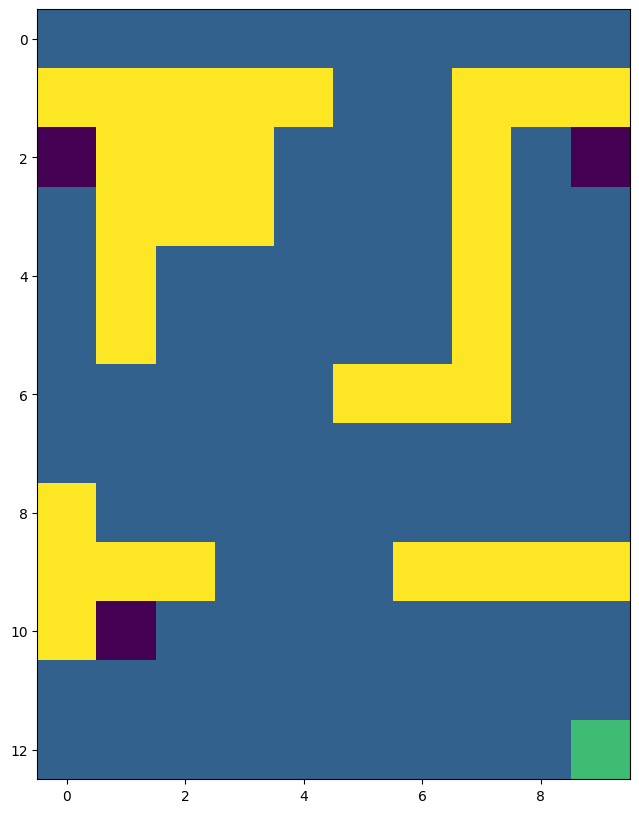

Results of the MC agent, FirstVisit, episodes:1, decay: 1.0, params: 0.0 batch-limit: 1000 policy-improvement: E-GREEDY :

Results of the MC agent, FirstVisit, episodes:1, decay: 1.0, params: 0.05 batch-limit: 1000 policy-improvement: E-GREEDY :

Results of the MC agent, FirstVisit, episodes:1, decay: 1.0, params: 0.1 batch-limit: 1000 policy-improvement: E-GREEDY :

Results of the MC agent, FirstVisit, episodes:1, decay: 1.0, params: 0.15 batch-limit: 1000 policy-improvement: E-GREEDY :

Results of the MC agent, FirstVisit, episodes:1, decay: 1.0, params: 0.2 batch-limit: 1000 policy-improvement: E-GREEDY :

Results of the MC agent, FirstVisit, episodes:1, decay: 1.0, params: 0.25 batch-limit: 1000 policy-improvement: E-GREEDY :

Results of the MC agent, FirstVisit, episodes:1, decay: 1.0, params: 0.3 batch-limit: 1000 policy-improvement: E-GREEDY :

Results of the MC agent, FirstVisit, episodes:1, decay: 1.0, params: 0.35 batch-limit: 1000 policy-improvement: E-GREEDY :

Results of t

KeyboardInterrupt: 

In [41]:
### Question 0: Defining the environment

print("Creating the Maze:\n")
maze = Maze()


MC_Visits = [True, False] # First visit, every visit
MC_Episodes_in_Batch = [1,2,3,4,5]
MC_Exploration_Params = [ i/100 for i in range(0, 105, 5)]
MC_Exploration_Decay = [ i / 1000 for i in range(1000, 950, -5)]
MC_Batch_Limit = [i for i in range(1000, 10000, 1000)]
MC_Policy_Improvement_Type = ["E-GREEDY", "COMBINATION", "SOFT-MAX"]

combinations = []

for policy_improvement in MC_Policy_Improvement_Type:
    for batch_limit in MC_Batch_Limit:
        for episodes in MC_Episodes_in_Batch:
            for visit_type in MC_Visits:
                for exploratory_decay in MC_Exploration_Decay:
                    for exploratory_param in MC_Exploration_Params:
                        combinations.append([policy_improvement, batch_limit, episodes, visit_type, exploratory_decay, exploratory_param])

for parameters in combinations:
    [policy_improvement, batch_limit, episodes, visit_type, exploratory_decay, exploratory_param] = parameters

    mc_agent = MC_agent()
    mc_policy, mc_values, total_rewards, batches = mc_agent.solve(maze, FIRST_VISIT_MC=visit_type, episodes_in_batch=episodes, exploration_param=exploratory_param, exploration_decay=exploratory_decay, batch_limit=batch_limit, policy_improvement_type=policy_improvement)

    def visit_type_string(is_first_visit):
        if is_first_visit: return "FirstVisit"
        return "EveryVisit"

    # test function
    visualize_value_policy_and_hyperparameters(maze_env=maze, policy=mc_policy, V=mc_values[-1],  hyperparams=[policy_improvement, batch_limit, episodes, visit_type, exploratory_decay, exploratory_param], filename=f"./images/MC/VFunction-{visit_type_string(visit_type)}-{episodes}-{exploratory_decay}-{exploratory_param}-{batch_limit}-{policy_improvement}.png" )

    print(f"Results of the MC agent, {visit_type_string(visit_type)}, episodes:{episodes}, decay: {exploratory_decay}, params: {exploratory_param} batch-limit: {batch_limit} policy-improvement: {policy_improvement} :\n")
    # maze.get_graphics().draw_policy(mc_policy)
    # maze.get_graphics().draw_value(mc_values[-1])

Text(0, 0.5, 'Learning Rate')

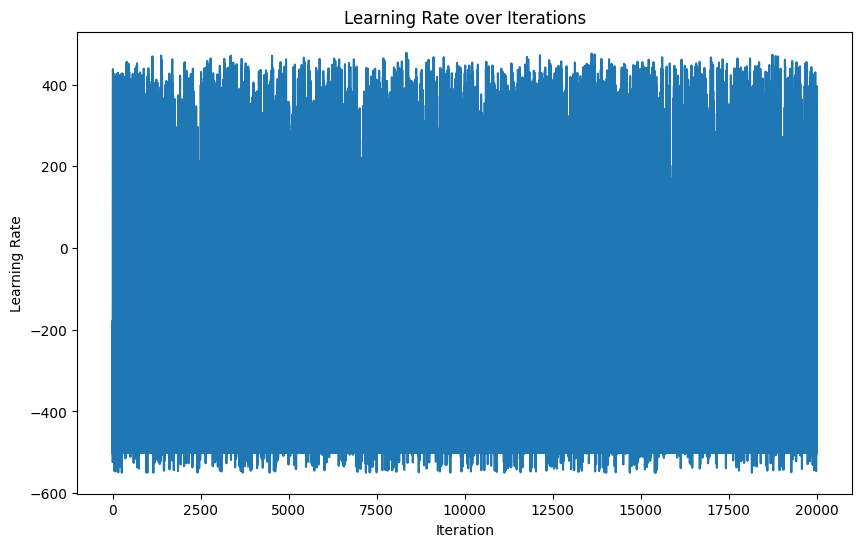

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(total_rewards)
plt.title("Learning Rate over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Learning Rate")

In [101]:
 import os
import imageio

# Visualising the episodes.
def visualize_episode_path(maze_env, episode, upto_timestep, filename):
    n, m = maze_env._shape
    grid = np.zeros(maze_env._shape)

    # Extract past states up to the current timestep
    past_states = [maze_env._get_loc_from_state(t[1]) for t in episode[:upto_timestep+1]]

    # Set alpha decrement based on the number of states to visualize
    decrement = 0.5 / len(past_states)
    alpha = 1.0

    # Fill in the grid based on the past states
    for (agent_i, agent_j) in reversed(past_states):
        if grid[agent_i][agent_j] < alpha:  # Only update if the current opacity is less than the new one
            grid[agent_i][agent_j] = alpha
        alpha -= decrement

    fig, ax = plt.subplots(figsize=(m, n))
    cax = ax.matshow(grid, cmap='viridis')  # Use a colormap to visualize the path

    # Mark obstacles and absorbing states
    for i, j in maze_env._obstacle_locs:
        ax.text(j, i, '█', ha='center', va='center', fontsize=12, color='white')
    for i, j in maze_env._absorbing_locs:
        ax.text(j, i, 'A', ha='center', va='center', fontsize=12, color='white')

    ax.set_xticks(np.arange(-0.5, m, 1))
    ax.set_yticks(np.arange(-0.5, n, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(which='both')

    plt.savefig(filename, dpi=30)
    plt.close()


def generate_gif(maze, episode, fs):
    image_filenames = []
    episode_length = len(episode)
    for idx in range(episode_length):
        print(f"Completed Step {idx}/{episode_length}")
        filename = f"./images/MC/Episodes/path_upto_timestep_{idx}.png"
        visualize_episode_path(maze, episode, idx, filename)
        image_filenames.append(filename)

    with imageio.get_writer(fs, mode='I', duration=0.5) as writer:  # 0.5 seconds per frame
        for filename in image_filenames:
            image = imageio.imread(filename)
            writer.append_data(image)
            os.remove(filename)

generate_gif(maze, batches[1000][0], "./images/MC/episode_1000.gif")
generate_gif(maze, batches[2000][0], "./images/MC/episode_2000.gif")
generate_gif(maze, batches[3000][0], "./images/MC/episode_3000.gif")
generate_gif(maze, batches[4000][0], "./images/MC/episode_4000.gif")
generate_gif(maze, batches[5000][0], "./images/MC/episode_5000.gif")
generate_gif(maze, batches[6000][0], "./images/MC/episode_6000.gif")
generate_gif(maze, batches[7000][0], "./images/MC/episode_7000.gif")

Completed Step 0/223
Completed Step 1/223
Completed Step 2/223
Completed Step 3/223
Completed Step 4/223
Completed Step 5/223
Completed Step 6/223
Completed Step 7/223
Completed Step 8/223
Completed Step 9/223
Completed Step 10/223
Completed Step 11/223
Completed Step 12/223
Completed Step 13/223
Completed Step 14/223
Completed Step 15/223
Completed Step 16/223
Completed Step 17/223
Completed Step 18/223
Completed Step 19/223
Completed Step 20/223
Completed Step 21/223
Completed Step 22/223
Completed Step 23/223
Completed Step 24/223
Completed Step 25/223
Completed Step 26/223
Completed Step 27/223
Completed Step 28/223
Completed Step 29/223
Completed Step 30/223
Completed Step 31/223
Completed Step 32/223
Completed Step 33/223
Completed Step 34/223
Completed Step 35/223
Completed Step 36/223
Completed Step 37/223
Completed Step 38/223
Completed Step 39/223
Completed Step 40/223
Completed Step 41/223
Completed Step 42/223
Completed Step 43/223
Completed Step 44/223
Completed Step 45/22

/var/folders/vg/74v_v08n4wxftghd_jwkbqt40000gn/T/ipykernel_27007/1656397134.py:52: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


Completed Step 0/230
Completed Step 1/230
Completed Step 2/230
Completed Step 3/230
Completed Step 4/230
Completed Step 5/230
Completed Step 6/230
Completed Step 7/230
Completed Step 8/230
Completed Step 9/230
Completed Step 10/230
Completed Step 11/230
Completed Step 12/230
Completed Step 13/230
Completed Step 14/230
Completed Step 15/230
Completed Step 16/230
Completed Step 17/230
Completed Step 18/230
Completed Step 19/230
Completed Step 20/230
Completed Step 21/230
Completed Step 22/230
Completed Step 23/230
Completed Step 24/230
Completed Step 25/230
Completed Step 26/230
Completed Step 27/230
Completed Step 28/230
Completed Step 29/230
Completed Step 30/230
Completed Step 31/230
Completed Step 32/230
Completed Step 33/230
Completed Step 34/230
Completed Step 35/230
Completed Step 36/230
Completed Step 37/230
Completed Step 38/230
Completed Step 39/230
Completed Step 40/230
Completed Step 41/230
Completed Step 42/230
Completed Step 43/230
Completed Step 44/230
Completed Step 45/23

/var/folders/vg/74v_v08n4wxftghd_jwkbqt40000gn/T/ipykernel_27007/1656397134.py:52: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


Completed Step 0/129
Completed Step 1/129
Completed Step 2/129
Completed Step 3/129
Completed Step 4/129
Completed Step 5/129
Completed Step 6/129
Completed Step 7/129
Completed Step 8/129
Completed Step 9/129
Completed Step 10/129
Completed Step 11/129
Completed Step 12/129
Completed Step 13/129
Completed Step 14/129
Completed Step 15/129
Completed Step 16/129
Completed Step 17/129
Completed Step 18/129
Completed Step 19/129
Completed Step 20/129
Completed Step 21/129
Completed Step 22/129
Completed Step 23/129
Completed Step 24/129
Completed Step 25/129
Completed Step 26/129
Completed Step 27/129
Completed Step 28/129
Completed Step 29/129
Completed Step 30/129
Completed Step 31/129
Completed Step 32/129
Completed Step 33/129
Completed Step 34/129
Completed Step 35/129
Completed Step 36/129
Completed Step 37/129
Completed Step 38/129
Completed Step 39/129
Completed Step 40/129
Completed Step 41/129
Completed Step 42/129
Completed Step 43/129
Completed Step 44/129
Completed Step 45/12

/var/folders/vg/74v_v08n4wxftghd_jwkbqt40000gn/T/ipykernel_27007/1656397134.py:52: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


Completed Step 0/502
Completed Step 1/502
Completed Step 2/502
Completed Step 3/502
Completed Step 4/502
Completed Step 5/502
Completed Step 6/502
Completed Step 7/502
Completed Step 8/502
Completed Step 9/502
Completed Step 10/502
Completed Step 11/502
Completed Step 12/502
Completed Step 13/502
Completed Step 14/502
Completed Step 15/502
Completed Step 16/502
Completed Step 17/502
Completed Step 18/502
Completed Step 19/502
Completed Step 20/502
Completed Step 21/502
Completed Step 22/502
Completed Step 23/502
Completed Step 24/502
Completed Step 25/502
Completed Step 26/502
Completed Step 27/502
Completed Step 28/502
Completed Step 29/502
Completed Step 30/502
Completed Step 31/502
Completed Step 32/502
Completed Step 33/502
Completed Step 34/502
Completed Step 35/502
Completed Step 36/502
Completed Step 37/502
Completed Step 38/502
Completed Step 39/502
Completed Step 40/502
Completed Step 41/502
Completed Step 42/502
Completed Step 43/502
Completed Step 44/502
Completed Step 45/50

/var/folders/vg/74v_v08n4wxftghd_jwkbqt40000gn/T/ipykernel_27007/1656397134.py:52: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


Completed Step 0/229
Completed Step 1/229
Completed Step 2/229
Completed Step 3/229
Completed Step 4/229
Completed Step 5/229
Completed Step 6/229
Completed Step 7/229
Completed Step 8/229
Completed Step 9/229
Completed Step 10/229
Completed Step 11/229
Completed Step 12/229
Completed Step 13/229
Completed Step 14/229
Completed Step 15/229
Completed Step 16/229
Completed Step 17/229
Completed Step 18/229
Completed Step 19/229
Completed Step 20/229
Completed Step 21/229
Completed Step 22/229
Completed Step 23/229
Completed Step 24/229
Completed Step 25/229
Completed Step 26/229
Completed Step 27/229
Completed Step 28/229
Completed Step 29/229
Completed Step 30/229
Completed Step 31/229
Completed Step 32/229
Completed Step 33/229
Completed Step 34/229
Completed Step 35/229
Completed Step 36/229
Completed Step 37/229
Completed Step 38/229
Completed Step 39/229
Completed Step 40/229
Completed Step 41/229
Completed Step 42/229
Completed Step 43/229
Completed Step 44/229
Completed Step 45/22

/var/folders/vg/74v_v08n4wxftghd_jwkbqt40000gn/T/ipykernel_27007/1656397134.py:52: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


Completed Step 0/422
Completed Step 1/422
Completed Step 2/422
Completed Step 3/422
Completed Step 4/422
Completed Step 5/422
Completed Step 6/422
Completed Step 7/422
Completed Step 8/422
Completed Step 9/422
Completed Step 10/422
Completed Step 11/422
Completed Step 12/422
Completed Step 13/422
Completed Step 14/422
Completed Step 15/422
Completed Step 16/422
Completed Step 17/422
Completed Step 18/422
Completed Step 19/422
Completed Step 20/422
Completed Step 21/422
Completed Step 22/422
Completed Step 23/422
Completed Step 24/422
Completed Step 25/422
Completed Step 26/422
Completed Step 27/422
Completed Step 28/422
Completed Step 29/422
Completed Step 30/422
Completed Step 31/422
Completed Step 32/422
Completed Step 33/422
Completed Step 34/422
Completed Step 35/422
Completed Step 36/422
Completed Step 37/422
Completed Step 38/422
Completed Step 39/422
Completed Step 40/422
Completed Step 41/422
Completed Step 42/422
Completed Step 43/422
Completed Step 44/422
Completed Step 45/42

/var/folders/vg/74v_v08n4wxftghd_jwkbqt40000gn/T/ipykernel_27007/1656397134.py:52: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


Completed Step 0/313
Completed Step 1/313
Completed Step 2/313
Completed Step 3/313
Completed Step 4/313
Completed Step 5/313
Completed Step 6/313
Completed Step 7/313
Completed Step 8/313
Completed Step 9/313
Completed Step 10/313
Completed Step 11/313
Completed Step 12/313
Completed Step 13/313
Completed Step 14/313
Completed Step 15/313
Completed Step 16/313
Completed Step 17/313
Completed Step 18/313
Completed Step 19/313
Completed Step 20/313
Completed Step 21/313
Completed Step 22/313
Completed Step 23/313
Completed Step 24/313
Completed Step 25/313
Completed Step 26/313
Completed Step 27/313
Completed Step 28/313
Completed Step 29/313
Completed Step 30/313
Completed Step 31/313
Completed Step 32/313
Completed Step 33/313
Completed Step 34/313
Completed Step 35/313
Completed Step 36/313
Completed Step 37/313
Completed Step 38/313
Completed Step 39/313
Completed Step 40/313
Completed Step 41/313
Completed Step 42/313
Completed Step 43/313
Completed Step 44/313
Completed Step 45/31

/var/folders/vg/74v_v08n4wxftghd_jwkbqt40000gn/T/ipykernel_27007/1656397134.py:52: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


## TD agent

In [ ]:
# This class define the Temporal-Difference agent

class TD_agent(object):

  # [Action required]
  # WARNING: make sure this function can be called by the auto-marking script
  def solve(self, env):
    """
    Solve a given Maze environment using Temporal Difference learning
    input: env {Maze object} -- Maze to solve
    output: 
      - policy {np.array} -- Optimal policy found to solve the given Maze environment 
      - values {list of np.array} -- List of successive value functions for each episode 
      - total_rewards {list of float} -- Corresponding list of successive total non-discounted sum of reward for each episode 
    """

    # Initialisation (can be edited)
    Q = np.random.rand(env.get_state_size(), env.get_action_size()) 
    V = np.zeros(env.get_state_size())
    policy = np.zeros((env.get_state_size(), env.get_action_size())) 
    values = [V]
    total_rewards = []

    #### 
    # Add your code here
    # WARNING: this agent only has access to env.reset() and env.step()
    # You should not use env.get_T(), env.get_R() or env.get_absorbing() to compute any value
    ####
    
    return policy, values, total_rewards

## Example main

In [ ]:
# Example main (can be edited)

### Question 0: Defining the environment

print("Creating the Maze:\n")
maze = Maze()


### Question 1: Dynamic programming

dp_agent = DP_agent()
dp_policy, dp_value = dp_agent.solve(maze)

print("Results of the DP agent:\n")
maze.get_graphics().draw_policy(dp_policy)
maze.get_graphics().draw_value(dp_value)


### Question 2: Monte-Carlo learning

mc_agent = MC_agent()
mc_policy, mc_values, total_rewards = mc_agent.solve(maze)

print("Results of the MC agent:\n")
maze.get_graphics().draw_policy(mc_policy)
maze.get_graphics().draw_value(mc_values[-1])


### Question 3: Temporal-Difference learning

td_agent = TD_agent()
td_policy, td_values, total_rewards = td_agent.solve(maze)

print("Results of the TD agent:\n")
maze.get_graphics().draw_policy(td_policy)
maze.get_graphics().draw_value(td_values[-1])